<a href="https://colab.research.google.com/github/ayanomtk2025/SIGNATE_Beginner_55/blob/main/Begginner%E5%8F%8E%E5%85%A5%E4%BA%88%E6%B8%AC_%E6%9C%80%E7%B5%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ライブラリのインポート

In [ ]:
!pip install dask[dataframe]

In [ ]:
!pip install optuna

In [ ]:
!pip install category_encoders

In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import optuna

import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
import xgboost as xgb


from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings('ignore') #警告非表示

%matplotlib inline

In [ ]:
pd.set_option('display.max_rows', None)

データの読み込み

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/datascience-for-beginner/【第55回_Beginner限定コンペ】国勢調査からの収入予測/train.csv")
train_df.head(5)

,index,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,native-country,Y
0,322,21,Private,Some-college,10,Divorced,Adm-clerical,Own-child,White,Female,United-States,0
1,11968,29,Private,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,United-States,0
2,10868,19,Private,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,United-States,0
3,3394,17,Private,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,United-States,0
4,15993,47,Private,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,0


In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/datascience-for-beginner/【第55回_Beginner限定コンペ】国勢調査からの収入予測/test.csv")
test_df.head()

,index,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,native-country
0,3625,23,Private,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,United-States
1,3028,19,Private,11th,7,Never-married,Handlers-cleaners,Own-child,White,Female,United-States
2,13814,30,State-gov,HS-grad,9,Never-married,Protective-serv,Unmarried,Black,Female,United-States
3,15398,60,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
4,13244,19,Private,HS-grad,9,Never-married,Sales,Own-child,White,Male,United-States


In [ ]:
train_df.info()

In [ ]:
test_df.info()

欠損値確認

In [ ]:
# '?' を NaN に変換
train_df.replace('?', np.nan, inplace=True)
test_df.replace('?', np.nan, inplace=True)

特徴量生成

In [ ]:
train_df["age_education-num"] = train_df["age"] * train_df["education-num"]

test_df["age_education-num"] = test_df["age"] * test_df["education-num"]

ageを3段階程度に場合分け * education_num

In [ ]:
def age_group(x):
    x = int(x)
    x = abs(x)
    if( 18 < x < 31 ):
        return "young"
    if( 30 < x < 61 ):
        return "middle"
    else:
        return "old"

train_df['age_group'] = train_df['age'].apply(age_group)
test_df['age_group'] = test_df['age'].apply(age_group)

In [ ]:
test_df['age_group'].head(5)

,age_group
0,young
1,young
2,young
3,middle
4,young


In [ ]:
age_order = {
    "young": 1, "old": 2, "middle": 3
}
train_df["age_group"] = train_df["age_group"].map(age_order)
test_df["age_group"] = test_df["age_group"].map(age_order)

In [ ]:
train_df["age_group"] = train_df["age_group"] * train_df["education-num"]
test_df["age_group"] = test_df["age_group"] * test_df["education-num"]

カテゴリカラムのターゲットエンコーディング

In [ ]:
def target_encoding(train_df, test_df, columns):
    for col in columns:
        mean_encoded_col = train_df.groupby(col)["Y"].mean()
        train_df[col + "_te"] = train_df[col].map(mean_encoded_col).fillna(mean_encoded_col.mean())
        test_df[col + "_te"] = test_df[col].map(mean_encoded_col).fillna(mean_encoded_col.mean())
    return train_df, test_df

# ターゲットエンコーディングを適用
te_columns = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
# ["education", "occupation", "workclass", "marital-status", "relationship"]
train_df, test_df = target_encoding(train_df, test_df, te_columns)

ターゲットエンコーディングしたカラムを掛け合わせて特徴量生成

In [ ]:
train_df["education_occupation_te"] = train_df["education_te"] * train_df["occupation_te"]
train_df["education_workclass_te"] = train_df["education_te"] * train_df["workclass_te"]
train_df["workclass_occupation_te"] = train_df["workclass_te"] * train_df["occupation_te"]
train_df["education_marital_te"] = train_df["education_te"] * train_df["marital-status_te"]
train_df["occupation_marital_te"] = train_df["occupation_te"] * train_df["marital-status_te"]
train_df["workclass_marital_te"] = train_df["workclass_te"] * train_df["marital-status_te"]
train_df["race_marital_te"] = train_df["race_te"] * train_df["marital-status_te"]
train_df["sex_marital_te"] = train_df["sex_te"] * train_df["marital-status_te"]
train_df["country_marital_te"] = train_df["native-country_te"] * train_df["marital-status_te"]
train_df["marital_relationship_te"] = train_df["marital-status_te"] * train_df["relationship_te"]


test_df["education_occupation_te"] = test_df["education_te"] * test_df["occupation_te"]
test_df["education_workclass_te"] = test_df["education_te"] * test_df["workclass_te"]
test_df["workclass_occupation_te"] = test_df["workclass_te"] * test_df["occupation_te"]
test_df["education_marital_te"] = test_df["education_te"] * test_df["marital-status_te"]
test_df["occupation_marital_te"] = test_df["occupation_te"] * test_df["marital-status_te"]
test_df["workclass_marital_te"] = test_df["workclass_te"] * test_df["marital-status_te"]
test_df["race_marital_te"] = test_df["race_te"] * test_df["marital-status_te"]
test_df["sex_marital_te"] = test_df["sex_te"] * test_df["marital-status_te"]
test_df["country_marital_te"] = test_df["native-country_te"] * test_df["marital-status_te"]
test_df["marital_relationship_te"] = test_df["marital-status_te"] * test_df["relationship_te"]

In [ ]:
train_df["workclass_te_education-num"] = train_df["workclass_te"] * train_df["education-num"]
train_df["education-num_marital"] = train_df["marital-status_te"] * train_df["education-num"]

test_df["workclass_te_education-num"] = test_df["workclass_te"] * test_df["education-num"]
test_df["education-num_marital"] = test_df["marital-status_te"] * test_df["education-num"]

教育レベルの二値化（大学卒業以上 or 未満）

In [ ]:
train_df["is_college_grad"] = train_df["education"].isin(
    ["Bachelors", "Masters", "Prof-school"]
).astype(int)

test_df["is_college_grad"] = train_df["education"].isin(
    ["Bachelors", "Masters", "Prof-school"]
).astype(int)

既婚男性フラグ

In [ ]:
train_df["is_married_male"] = ((train_df["marital-status"] == "Married-civ-spouse") & (train_df["sex"] == "Male")).astype(int)
test_df["is_married_male"] = ((test_df["marital-status"] == "Married-civ-spouse") & (test_df["sex"] == "Male")).astype(int)

不要カラムの処理

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11043 entries, 0 to 11042
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       11043 non-null  int64  
 1   age                         11043 non-null  int64  
 2   workclass                   10542 non-null  object 
 3   education                   11043 non-null  object 
 4   education-num               11043 non-null  int64  
 5   marital-status              11043 non-null  object 
 6   occupation                  10479 non-null  object 
 7   relationship                11043 non-null  object 
 8   race                        11043 non-null  object 
 9   sex                         11043 non-null  object 
 10  native-country              11043 non-null  object 
 11  Y                           11043 non-null  int64  
 12  age_education-num           11043 non-null  int64  
 13  age_group                   110

In [ ]:
#train_df = train_df.drop(columns=["workclass", "education", "marital-status", "occupation"])
#test_df = test_df.drop(columns=["workclass", "education", "marital-status", "occupation"])

カテゴリカラムのワンホットエンコーディング

In [ ]:
## 文字列（カテゴリ）カラムをワンホットエンコーディング
#train_df_onehot = train_df.copy()
#train_df_onehot = pd.get_dummies(train_df_onehot, dtype=np.int8)
#test_df_onehot = test_df.copy()
#test_df_onehot = pd.get_dummies(test_df_onehot, dtype=np.int8)

In [ ]:
def onehot_encode_selected_columns(train_df, columns):

    df_encoded = train_df.copy()
    df_encoded = pd.get_dummies(df_encoded, columns=columns, dtype=np.int8)
    return df_encoded

# 使用例
# train_df, test_df はそれぞれ元のデータフレーム
# encode_columns はワンホットエンコーディングしたいカラム名のリスト

#encode_columns = ["race", "sex", "native-country"] # 例：ワンホットエンコーディングしたいカラムを指定
encode_columns = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

train_df_onehot = onehot_encode_selected_columns(train_df, encode_columns)
test_df_onehot = onehot_encode_selected_columns(test_df, encode_columns)

In [ ]:
train_df_onehot.head(5)

,index,age,education-num,Y,age_education-num,age_group,workclass_te,education_te,marital-status_te,occupation_te,...,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_White,sex_Female,sex_Male,native-country_Mexico,native-country_Philippines,native-country_United-States
0,322,21,10,0,210,10,0.228088,0.202239,0.051687,0.111380,...,0,0,0,0,1,1,0,0,0,1
1,11968,29,9,0,261,9,0.228088,0.164938,0.051687,0.111380,...,0,0,0,0,1,1,0,0,0,1
2,10868,19,13,0,247,13,0.228088,0.402299,0.019784,0.464662,...,0,0,0,0,1,1,0,0,0,1
3,3394,17,9,0,153,18,0.228088,0.164938,0.019784,0.195954,...,0,0,0,0,1,0,1,0,0,1
4,15993,47,10,0,470,30,0.228088,0.202239,0.465888,0.195954,...,0,0,0,0,1,0,1,0,0,1


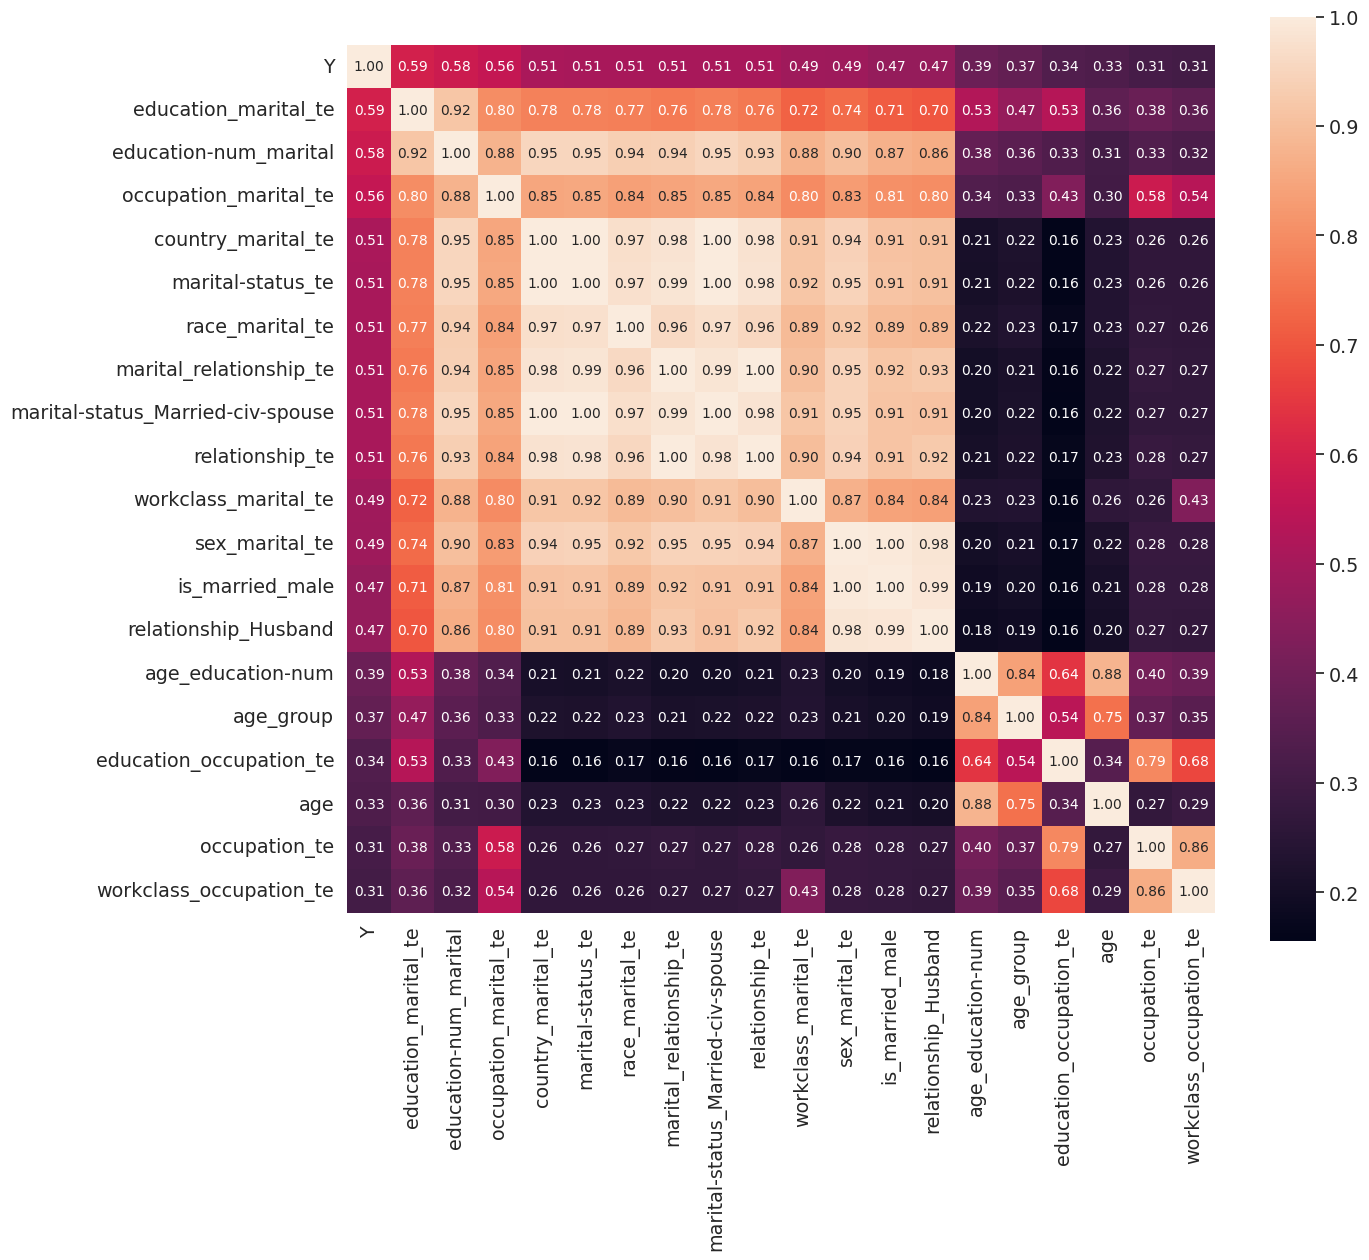

In [ ]:
# One-Hotエンコード後の相関行列を計算する
corrmat_onehot = train_df_onehot.corr()

k = 20  # ヒートマップの変数の数
# One-Hotエンコードされたデータフレームの相関行列から、'Y'と相関する上位k個の特徴量を取得する
cols = corrmat_onehot.nlargest(k, "Y")["Y"].index

cm = np.corrcoef(train_df_onehot[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize=(14, 12))  # 変更: グラフサイズを大きくする
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

データセット作成

In [ ]:
x_train = train_df_onehot.drop(train_df_onehot[["Y", "index", "sex_Female"]], axis=1)
y_train = train_df_onehot["Y"]

In [ ]:
x_test = test_df_onehot.drop(test_df_onehot[["index", "sex_Female"]], axis=1)

In [ ]:
missing_cols = set(x_test.columns) - set(x_train.columns)
missing_cols

set()

In [ ]:
missing_cols = set(x_train.columns) - set(x_test.columns)
missing_cols

set()

バリデーション~モデル評価

カラム名のクリーニング

In [ ]:
#import re
#
## Function to clean column names
#def clean_col_names(train_df_onehot):
#    train_df_onehot.columns = [re.sub(r'[ <>{},\[\]]', '_', col) for col in train_df_onehot.columns]
#    # Replaces special chars with '_'
#    return train_df_onehot
#
## Apply the cleaning function before model training
#x_train = clean_col_names(x_train)
#x_test = clean_col_names(x_test)

In [ ]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
#    "scale_pos_weight": 3,  # 多数クラス / 少数クラス に合わせる
    "metric": "auc",
    "learning_rate": 0.14,
    "num_leaves": 56,
    "n_estimators": 129,
    "max_depth": 3,
    "min_child_samples": 51,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    "reg_alpha": 3,
    "random_state": 123,
    "importance_type": "gain",
    "verbose": -1
}

In [ ]:
metrics = []
imp = pd.DataFrame()

#クロスバリデーション
n_splits = 5

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

for nfold, (train_idx, val_idx) in enumerate(cv.split(x_train, y_train)):
    print("-"*10, nfold, "-"*10)

    x_tr, y_tr = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_va, y_va = x_train.iloc[val_idx], y_train.iloc[val_idx]

    print("学習用:", x_tr.shape, y_tr.shape)
    print("評価用:", x_va.shape, y_va.shape)

    lgb_model = lgb.LGBMClassifier(**params)
    lgb_model.fit(
        x_tr,
        y_tr,
        eval_set=[(x_tr, y_tr), (x_va, y_va)],
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=50),
            lgb.callback.log_evaluation(period=100)
            ])

#モデル評価
    y_tr_pred = lgb_model.predict(x_tr)
    y_va_pred = lgb_model.predict(x_va)

    metric_tr = accuracy_score(y_tr, y_tr_pred)
    metric_va = accuracy_score(y_va, y_va_pred)

    print(metric_tr, metric_va)

    metrics.append([nfold, metric_tr, metric_va])

#feature importance
    _imp = pd.DataFrame({
        "col": x_train.columns,
        "imp": lgb_model.feature_importances_,
        "nfold": nfold
    })

    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

---------- 0 ----------
学習用: (8834, 75) (8834,)
評価用: (2209, 75) (2209,)
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.915744	valid_1's auc: 0.899076
Did not meet early stopping. Best iteration is:
[128]	training's auc: 0.917694	valid_1's auc: 0.899495
0.8609916232737151 0.8401991851516524
---------- 1 ----------
学習用: (8834, 75) (8834,)
評価用: (2209, 75) (2209,)
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.912923	valid_1's auc: 0.909121
Did not meet early stopping. Best iteration is:
[129]	training's auc: 0.91477	valid_1's auc: 0.910076
0.856690061127462 0.8528746038931643
---------- 2 ----------
学習用: (8834, 75) (8834,)
評価用: (2209, 75) (2209,)
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.913628	valid_1's auc: 0.90664
Did not meet early stopping. Best iteration is:
[123]	training's auc: 0.915329	valid_1's auc: 0.907005
0.8573692551505546 0.8569488456315074
---------- 3 ---

In [ ]:
import numpy as np
metrics = np.array(metrics)
print("[tr]: {:3f}+-{:2f}".format(metrics[:, 1].mean(), metrics[:, 1].std()))
print("[va]: {:3f}+-{:2f}".format(metrics[:, 2].mean(), metrics[:, 2].std()))

[tr]: 0.857829+-0.001622
[va]: 0.849860+-0.007180


In [ ]:
imp = imp.groupby("col")["imp"].agg(["mean", "std"])
imp.columns = ["imp", "imp_std"]
imp = imp.reset_index(drop=False).sort_values(by="imp", ascending=False)
imp

,col,imp,imp_std
5,education-num_marital,5248.171857,620.659878
19,education_marital_te,3002.892520,560.812544
20,education_occupation_te,1575.975165,105.305591
61,relationship_te,1278.673645,327.006299
48,occupation_marital_te,1240.367360,463.195657
1,age_education-num,928.759438,214.895013
0,age,916.707885,56.703139
21,education_te,490.632120,45.372652
31,marital_relationship_te,321.497059,275.162736
2,age_group,269.665993,36.543911


In [ ]:
# 最適パラメータでモデルを学習
final_model = train_best_model(x_train, y_train, params)

# 評価用データでのモデル評価
y_tr_pred = final_model.predict_proba(x_train)[:, 1]
train_auc = roc_auc_score(y_train, y_tr_pred)
print("Test AUC:", train_auc)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[128]	valid_0's auc: 0.899495
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[129]	valid_0's auc: 0.910076
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[123]	valid_0's auc: 0.907005
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[103]	valid_0's auc: 0.908985
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.898707
Final Model AUC: 0.9048536145086092
Test AUC: 0.9117269926361531


サブミット

In [ ]:
y_test_pred = final_model.predict(x_test)

In [ ]:
submit_df = pd.DataFrame({
    "index": test_df["index"],
    "Y": y_test_pred
})

In [ ]:
submit_df.to_csv("submit.csv", index=False, header=False)